In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
ACANET_MODEL = ACANet_GIN

In [6]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    
    model = ACANET_MODEL(**pub_args, train_eps = True).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [7]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            # 'aggregators': ['mean', 'min', 'max', 'sum','std'],
            # 'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [8]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [9]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 12.2169 tsm_loss: 5.6128 reg_loss: 6.6041 n_pos_triplets: 220218;  Val: 6.6338 Test: 6.6553
Epoch: 002, Loss: 10.8433 tsm_loss: 4.6742 reg_loss: 6.1691 n_pos_triplets: 214672;  Val: 6.5979 Test: 6.6187
Epoch: 003, Loss: 9.8324 tsm_loss: 4.2639 reg_loss: 5.5685 n_pos_triplets: 215424;  Val: 6.4137 Test: 6.4308
Epoch: 004, Loss: 8.3810 tsm_loss: 3.7004 reg_loss: 4.6806 n_pos_triplets: 211580;  Val: 5.9056 Test: 5.9181
Epoch: 005, Loss: 6.7112 tsm_loss: 3.2691 reg_loss: 3.4421 n_pos_triplets: 210668;  Val: 4.8523 Test: 4.8627
Epoch: 006, Loss: 4.8344 tsm_loss: 3.0232 reg_loss: 1.8112 n_pos_triplets: 210166;  Val: 3.1186 Test: 3.1321
Epoch: 007, Loss: 3.8548 tsm_loss: 2.7685 reg_loss: 1.0863 n_pos_triplets: 206288;  Val: 1.5612 Test: 1.5742
Epoch: 008, Loss: 3.7627 tsm_loss: 2.4861 reg_loss: 1.2767 n_pos_triplets: 199487;  Val: 1.2704 Test: 1.2653
Epoch: 009, Loss: 3.2329 tsm_loss: 2.3298 reg_loss: 0.9032 n_pos_triplets: 195429;  Val: 1.4226 Test: 1.4066
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4826 tsm_loss: 9.0171 reg_loss: 6.4826 n_pos_triplets: 218252;  Val: 6.7467 Test: 6.7681
Epoch: 002, Loss: 5.8593 tsm_loss: 8.9556 reg_loss: 5.8593 n_pos_triplets: 217765;  Val: 6.7256 Test: 6.7457
Epoch: 003, Loss: 5.0048 tsm_loss: 8.8505 reg_loss: 5.0048 n_pos_triplets: 218354;  Val: 6.5414 Test: 6.5614
Epoch: 004, Loss: 3.8143 tsm_loss: 8.7391 reg_loss: 3.8143 n_pos_triplets: 216682;  Val: 6.0344 Test: 6.0539
Epoch: 005, Loss: 2.3134 tsm_loss: 8.4751 reg_loss: 2.3134 n_pos_triplets: 216885;  Val: 5.0028 Test: 5.0207
Epoch: 006, Loss: 1.4482 tsm_loss: 7.7307 reg_loss: 1.4482 n_pos_triplets: 216704;  Val: 3.5777 Test: 3.5891
Epoch: 007, Loss: 1.3955 tsm_loss: 6.8939 reg_loss: 1.3955 n_pos_triplets: 215122;  Val: 2.8484 Test: 2.8374
Epoch: 008, Loss: 0.9520 tsm_loss: 6.0582 reg_loss: 0.9520 n_pos_triplets: 211415;  Val: 2.5933 Test: 2.5568
Epoch: 009, Loss: 0.8847 tsm_loss: 5.5149 reg_loss: 0.8847 n_pos_triplets: 204566;  Val: 2.0747 Test: 2.0077
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 13.0483 tsm_loss: 6.4754 reg_loss: 6.5729 n_pos_triplets: 219065;  Val: 6.7884 Test: 6.6640
Epoch: 002, Loss: 11.1268 tsm_loss: 4.9803 reg_loss: 6.1466 n_pos_triplets: 217022;  Val: 6.7252 Test: 6.5996
Epoch: 003, Loss: 9.8899 tsm_loss: 4.2988 reg_loss: 5.5910 n_pos_triplets: 214259;  Val: 6.5256 Test: 6.4003
Epoch: 004, Loss: 8.7136 tsm_loss: 3.8905 reg_loss: 4.8230 n_pos_triplets: 206126;  Val: 6.0373 Test: 5.9120
Epoch: 005, Loss: 7.0602 tsm_loss: 3.3461 reg_loss: 3.7141 n_pos_triplets: 203513;  Val: 5.0676 Test: 4.9407
Epoch: 006, Loss: 5.2370 tsm_loss: 3.0046 reg_loss: 2.2323 n_pos_triplets: 198113;  Val: 3.4898 Test: 3.3713
Epoch: 007, Loss: 3.8421 tsm_loss: 2.8189 reg_loss: 1.0232 n_pos_triplets: 196799;  Val: 1.7521 Test: 1.7055
Epoch: 008, Loss: 3.7359 tsm_loss: 2.5533 reg_loss: 1.1826 n_pos_triplets: 192270;  Val: 1.2934 Test: 1.3009
Epoch: 009, Loss: 3.2838 tsm_loss: 2.4062 reg_loss: 0.8777 n_pos_triplets: 186390;  Val: 1.4817 Test: 1.4242
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.7030 tsm_loss: 7.2657 reg_loss: 6.7030 n_pos_triplets: 216808;  Val: 6.9180 Test: 6.7926
Epoch: 002, Loss: 6.3405 tsm_loss: 7.2955 reg_loss: 6.3405 n_pos_triplets: 216725;  Val: 6.8290 Test: 6.7041
Epoch: 003, Loss: 5.8271 tsm_loss: 7.5819 reg_loss: 5.8271 n_pos_triplets: 216961;  Val: 6.6100 Test: 6.4848
Epoch: 004, Loss: 5.0366 tsm_loss: 7.2783 reg_loss: 5.0366 n_pos_triplets: 215428;  Val: 6.1287 Test: 6.0025
Epoch: 005, Loss: 3.9209 tsm_loss: 7.5510 reg_loss: 3.9209 n_pos_triplets: 215478;  Val: 5.2128 Test: 5.0869
Epoch: 006, Loss: 2.3636 tsm_loss: 7.5822 reg_loss: 2.3636 n_pos_triplets: 212317;  Val: 3.7494 Test: 3.6333
Epoch: 007, Loss: 1.3457 tsm_loss: 7.1550 reg_loss: 1.3457 n_pos_triplets: 213789;  Val: 2.2276 Test: 2.1551
Epoch: 008, Loss: 1.2146 tsm_loss: 5.8608 reg_loss: 1.2146 n_pos_triplets: 213005;  Val: 1.7417 Test: 1.6898
Epoch: 009, Loss: 0.8767 tsm_loss: 5.2840 reg_loss: 0.8767 n_pos_triplets: 209547;  Val: 1.7309 Test: 1.6511
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 13.0333 tsm_loss: 6.3149 reg_loss: 6.7184 n_pos_triplets: 215658;  Val: 6.7741 Test: 6.8211
Epoch: 002, Loss: 11.5231 tsm_loss: 5.2058 reg_loss: 6.3172 n_pos_triplets: 214492;  Val: 6.6906 Test: 6.7357
Epoch: 003, Loss: 10.2330 tsm_loss: 4.3846 reg_loss: 5.8483 n_pos_triplets: 215412;  Val: 6.5306 Test: 6.5698
Epoch: 004, Loss: 8.9404 tsm_loss: 3.7680 reg_loss: 5.1724 n_pos_triplets: 209843;  Val: 6.1413 Test: 6.1755
Epoch: 005, Loss: 7.6593 tsm_loss: 3.4161 reg_loss: 4.2432 n_pos_triplets: 207280;  Val: 5.3965 Test: 5.4276
Epoch: 006, Loss: 6.0426 tsm_loss: 3.0445 reg_loss: 2.9981 n_pos_triplets: 203320;  Val: 4.2016 Test: 4.2254
Epoch: 007, Loss: 4.3087 tsm_loss: 2.8052 reg_loss: 1.5035 n_pos_triplets: 203123;  Val: 2.5373 Test: 2.5591
Epoch: 008, Loss: 3.5494 tsm_loss: 2.5472 reg_loss: 1.0022 n_pos_triplets: 197225;  Val: 1.4080 Test: 1.4395
Epoch: 009, Loss: 3.4585 tsm_loss: 2.3988 reg_loss: 1.0597 n_pos_triplets: 195043;  Val: 1.3062 Test: 1.3431
Epoch: 010, Loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 173, Loss: 0.6100 tsm_loss: 0.3957 reg_loss: 0.2143 n_pos_triplets: 85263;  Val: 0.7932 Test: 0.7234
Epoch: 174, Loss: 0.6063 tsm_loss: 0.3902 reg_loss: 0.2161 n_pos_triplets: 86194;  Val: 0.7933 Test: 0.7176
Epoch: 175, Loss: 0.6096 tsm_loss: 0.3943 reg_loss: 0.2153 n_pos_triplets: 84885;  Val: 0.7980 Test: 0.7123
Epoch: 176, Loss: 0.6113 tsm_loss: 0.3817 reg_loss: 0.2297 n_pos_triplets: 86194;  Val: 0.7917 Test: 0.7200
Epoch: 177, Loss: 0.6592 tsm_loss: 0.3999 reg_loss: 0.2593 n_pos_triplets: 86707;  Val: 0.8302 Test: 0.7354
Epoch: 178, Loss: 0.6427 tsm_loss: 0.3765 reg_loss: 0.2662 n_pos_triplets: 82365;  Val: 0.8056 Test: 0.7244
Epoch: 179, Loss: 0.5905 tsm_loss: 0.3749 reg_loss: 0.2156 n_pos_triplets: 84395;  Val: 0.8006 Test: 0.7234
Epoch: 180, Loss: 0.6181 tsm_loss: 0.3869 reg_loss: 0.2312 n_pos_triplets: 84519;  Val: 0.8280 Test: 0.7501
Epoch: 181, Loss: 0.6215 tsm_loss: 0.3798 reg_loss: 0.2417 n_pos_triplets: 82878;  Val: 0.7965 Test: 0.7379
Epoch: 182, Loss: 0.6029 tsm

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.8394 tsm_loss: 7.5505 reg_loss: 6.8394 n_pos_triplets: 223500;  Val: 6.9187 Test: 6.9216
Epoch: 002, Loss: 6.4869 tsm_loss: 7.7241 reg_loss: 6.4869 n_pos_triplets: 224092;  Val: 6.8416 Test: 6.8438
Epoch: 003, Loss: 6.0759 tsm_loss: 7.9540 reg_loss: 6.0759 n_pos_triplets: 222488;  Val: 6.6735 Test: 6.6738
Epoch: 004, Loss: 5.4957 tsm_loss: 7.7588 reg_loss: 5.4957 n_pos_triplets: 222975;  Val: 6.3272 Test: 6.3212
Epoch: 005, Loss: 4.6475 tsm_loss: 7.8490 reg_loss: 4.6475 n_pos_triplets: 222644;  Val: 5.6875 Test: 5.6699
Epoch: 006, Loss: 3.5371 tsm_loss: 7.6794 reg_loss: 3.5371 n_pos_triplets: 217088;  Val: 4.6499 Test: 4.6126
Epoch: 007, Loss: 2.0805 tsm_loss: 7.3552 reg_loss: 2.0805 n_pos_triplets: 219610;  Val: 3.1616 Test: 3.0813
Epoch: 008, Loss: 1.3361 tsm_loss: 6.5281 reg_loss: 1.3361 n_pos_triplets: 215769;  Val: 1.8915 Test: 1.7318
Epoch: 009, Loss: 1.2684 tsm_loss: 5.6453 reg_loss: 1.2684 n_pos_triplets: 215634;  Val: 1.5895 Test: 1.3888
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 13.6135 tsm_loss: 6.9561 reg_loss: 6.6574 n_pos_triplets: 221409;  Val: 6.7303 Test: 6.6361
Epoch: 002, Loss: 11.9033 tsm_loss: 5.5708 reg_loss: 6.3324 n_pos_triplets: 217905;  Val: 6.6779 Test: 6.5836
Epoch: 003, Loss: 10.4733 tsm_loss: 4.5241 reg_loss: 5.9492 n_pos_triplets: 217496;  Val: 6.5508 Test: 6.4560
Epoch: 004, Loss: 9.4148 tsm_loss: 3.9801 reg_loss: 5.4347 n_pos_triplets: 213843;  Val: 6.2407 Test: 6.1455
Epoch: 005, Loss: 8.1459 tsm_loss: 3.4031 reg_loss: 4.7428 n_pos_triplets: 208876;  Val: 5.6438 Test: 5.5457
Epoch: 006, Loss: 6.9455 tsm_loss: 3.1349 reg_loss: 3.8106 n_pos_triplets: 207849;  Val: 4.6931 Test: 4.5923
Epoch: 007, Loss: 5.3987 tsm_loss: 2.8288 reg_loss: 2.5699 n_pos_triplets: 202342;  Val: 3.3297 Test: 3.2306
Epoch: 008, Loss: 3.8955 tsm_loss: 2.6379 reg_loss: 1.2576 n_pos_triplets: 200004;  Val: 1.7611 Test: 1.6837
Epoch: 009, Loss: 3.4553 tsm_loss: 2.4048 reg_loss: 1.0505 n_pos_triplets: 194927;  Val: 1.1833 Test: 1.1482
Epoch: 010, Loss

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5435 tsm_loss: 7.2847 reg_loss: 6.5435 n_pos_triplets: 222712;  Val: 6.8623 Test: 6.7693
Epoch: 002, Loss: 5.9357 tsm_loss: 7.4139 reg_loss: 5.9357 n_pos_triplets: 223281;  Val: 6.7956 Test: 6.7023
Epoch: 003, Loss: 5.1615 tsm_loss: 7.1138 reg_loss: 5.1615 n_pos_triplets: 220770;  Val: 6.5684 Test: 6.4739
Epoch: 004, Loss: 4.1081 tsm_loss: 6.8295 reg_loss: 4.1081 n_pos_triplets: 220310;  Val: 6.0033 Test: 5.9066
Epoch: 005, Loss: 2.6768 tsm_loss: 6.5201 reg_loss: 2.6768 n_pos_triplets: 218866;  Val: 4.8868 Test: 4.7842
Epoch: 006, Loss: 1.3481 tsm_loss: 6.2327 reg_loss: 1.3481 n_pos_triplets: 217725;  Val: 3.2599 Test: 3.1418
Epoch: 007, Loss: 1.2346 tsm_loss: 5.4992 reg_loss: 1.2346 n_pos_triplets: 216038;  Val: 2.2759 Test: 2.1370
Epoch: 008, Loss: 0.9523 tsm_loss: 4.7503 reg_loss: 0.9523 n_pos_triplets: 209520;  Val: 2.1642 Test: 2.0169
Epoch: 009, Loss: 0.7838 tsm_loss: 4.6466 reg_loss: 0.7838 n_pos_triplets: 205097;  Val: 1.9008 Test: 1.7494
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 13.0123 tsm_loss: 6.5858 reg_loss: 6.4265 n_pos_triplets: 214221;  Val: 6.7373 Test: 6.6599
Epoch: 002, Loss: 11.3241 tsm_loss: 5.5224 reg_loss: 5.8017 n_pos_triplets: 211241;  Val: 6.6269 Test: 6.5483
Epoch: 003, Loss: 9.4442 tsm_loss: 4.4924 reg_loss: 4.9518 n_pos_triplets: 206842;  Val: 6.2860 Test: 6.2063
Epoch: 004, Loss: 7.6795 tsm_loss: 3.9228 reg_loss: 3.7567 n_pos_triplets: 205328;  Val: 5.4362 Test: 5.3590
Epoch: 005, Loss: 5.6410 tsm_loss: 3.5236 reg_loss: 2.1174 n_pos_triplets: 202323;  Val: 3.8810 Test: 3.8178
Epoch: 006, Loss: 4.2111 tsm_loss: 3.1480 reg_loss: 1.0631 n_pos_triplets: 200805;  Val: 2.1391 Test: 2.1276
Epoch: 007, Loss: 4.0474 tsm_loss: 2.8319 reg_loss: 1.2155 n_pos_triplets: 195116;  Val: 1.7061 Test: 1.7331
Epoch: 008, Loss: 3.4547 tsm_loss: 2.5949 reg_loss: 0.8599 n_pos_triplets: 190637;  Val: 1.7660 Test: 1.8005
Epoch: 009, Loss: 3.3476 tsm_loss: 2.4692 reg_loss: 0.8784 n_pos_triplets: 192077;  Val: 1.4449 Test: 1.5157
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.6513 tsm_loss: 8.2632 reg_loss: 6.6513 n_pos_triplets: 220813;  Val: 6.9415 Test: 6.8635
Epoch: 002, Loss: 6.0824 tsm_loss: 8.1209 reg_loss: 6.0824 n_pos_triplets: 218653;  Val: 6.8671 Test: 6.7895
Epoch: 003, Loss: 5.3843 tsm_loss: 8.0098 reg_loss: 5.3843 n_pos_triplets: 217877;  Val: 6.6510 Test: 6.5698
Epoch: 004, Loss: 4.4247 tsm_loss: 7.5342 reg_loss: 4.4247 n_pos_triplets: 217656;  Val: 6.1229 Test: 6.0378
Epoch: 005, Loss: 3.1681 tsm_loss: 7.4625 reg_loss: 3.1681 n_pos_triplets: 217524;  Val: 5.1284 Test: 5.0452
Epoch: 006, Loss: 1.7897 tsm_loss: 6.9896 reg_loss: 1.7897 n_pos_triplets: 217269;  Val: 3.6164 Test: 3.5586
Epoch: 007, Loss: 1.2786 tsm_loss: 6.3057 reg_loss: 1.2786 n_pos_triplets: 213086;  Val: 2.2404 Test: 2.2586
Epoch: 008, Loss: 1.1479 tsm_loss: 5.7033 reg_loss: 1.1479 n_pos_triplets: 216688;  Val: 1.7576 Test: 1.8208
Epoch: 009, Loss: 0.8256 tsm_loss: 5.1431 reg_loss: 0.8256 n_pos_triplets: 206799;  Val: 1.6692 Test: 1.7341
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 13.4996 tsm_loss: 7.0662 reg_loss: 6.4334 n_pos_triplets: 220937;  Val: 6.6259 Test: 6.6157
Epoch: 002, Loss: 11.3530 tsm_loss: 5.4342 reg_loss: 5.9188 n_pos_triplets: 216823;  Val: 6.4916 Test: 6.4649
Epoch: 003, Loss: 9.8963 tsm_loss: 4.6382 reg_loss: 5.2581 n_pos_triplets: 217251;  Val: 6.2416 Test: 6.1941
Epoch: 004, Loss: 8.3730 tsm_loss: 3.9819 reg_loss: 4.3911 n_pos_triplets: 214156;  Val: 5.6897 Test: 5.6192
Epoch: 005, Loss: 6.8281 tsm_loss: 3.5632 reg_loss: 3.2649 n_pos_triplets: 209873;  Val: 4.7029 Test: 4.6064
Epoch: 006, Loss: 5.1074 tsm_loss: 3.2198 reg_loss: 1.8877 n_pos_triplets: 205236;  Val: 3.2183 Test: 3.0999
Epoch: 007, Loss: 4.0439 tsm_loss: 2.9472 reg_loss: 1.0966 n_pos_triplets: 202655;  Val: 1.7603 Test: 1.6629
Epoch: 008, Loss: 3.9757 tsm_loss: 2.7380 reg_loss: 1.2377 n_pos_triplets: 199434;  Val: 1.3885 Test: 1.3310
Epoch: 009, Loss: 3.4236 tsm_loss: 2.4771 reg_loss: 0.9465 n_pos_triplets: 195858;  Val: 1.5052 Test: 1.4431
Epoch: 010, Loss:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5948 tsm_loss: 7.7978 reg_loss: 6.5948 n_pos_triplets: 217099;  Val: 6.7608 Test: 6.7574
Epoch: 002, Loss: 6.2978 tsm_loss: 7.5642 reg_loss: 6.2978 n_pos_triplets: 216374;  Val: 6.7166 Test: 6.7067
Epoch: 003, Loss: 5.9392 tsm_loss: 7.3604 reg_loss: 5.9392 n_pos_triplets: 213098;  Val: 6.6057 Test: 6.5906
Epoch: 004, Loss: 5.3820 tsm_loss: 7.1053 reg_loss: 5.3820 n_pos_triplets: 216464;  Val: 6.3237 Test: 6.3000
Epoch: 005, Loss: 4.6185 tsm_loss: 6.7749 reg_loss: 4.6185 n_pos_triplets: 213918;  Val: 5.7830 Test: 5.7486
Epoch: 006, Loss: 3.5670 tsm_loss: 6.5910 reg_loss: 3.5670 n_pos_triplets: 214542;  Val: 4.8762 Test: 4.8311
Epoch: 007, Loss: 2.2018 tsm_loss: 6.4827 reg_loss: 2.2018 n_pos_triplets: 214681;  Val: 3.4958 Test: 3.4472
Epoch: 008, Loss: 1.2201 tsm_loss: 6.1920 reg_loss: 1.2201 n_pos_triplets: 214750;  Val: 2.0892 Test: 2.0443
Epoch: 009, Loss: 1.1930 tsm_loss: 5.3424 reg_loss: 1.1930 n_pos_triplets: 213403;  Val: 1.5657 Test: 1.5197
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 13.4568 tsm_loss: 6.8778 reg_loss: 6.5790 n_pos_triplets: 216905;  Val: 6.7952 Test: 6.6668
Epoch: 002, Loss: 11.6651 tsm_loss: 5.5149 reg_loss: 6.1502 n_pos_triplets: 213451;  Val: 6.7484 Test: 6.6200
Epoch: 003, Loss: 10.4316 tsm_loss: 4.7605 reg_loss: 5.6711 n_pos_triplets: 213083;  Val: 6.5845 Test: 6.4588
Epoch: 004, Loss: 9.2867 tsm_loss: 4.2765 reg_loss: 5.0102 n_pos_triplets: 210063;  Val: 6.1901 Test: 6.0701
Epoch: 005, Loss: 7.9899 tsm_loss: 3.8909 reg_loss: 4.0990 n_pos_triplets: 208500;  Val: 5.4216 Test: 5.3116
Epoch: 006, Loss: 6.4163 tsm_loss: 3.5549 reg_loss: 2.8614 n_pos_triplets: 206437;  Val: 4.1655 Test: 4.0715
Epoch: 007, Loss: 4.6126 tsm_loss: 3.1626 reg_loss: 1.4500 n_pos_triplets: 203746;  Val: 2.4398 Test: 2.3620
Epoch: 008, Loss: 4.1075 tsm_loss: 2.9974 reg_loss: 1.1101 n_pos_triplets: 200686;  Val: 1.4065 Test: 1.3467
Epoch: 009, Loss: 3.8886 tsm_loss: 2.7800 reg_loss: 1.1087 n_pos_triplets: 198759;  Val: 1.3874 Test: 1.3180
Epoch: 010, Loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [11]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

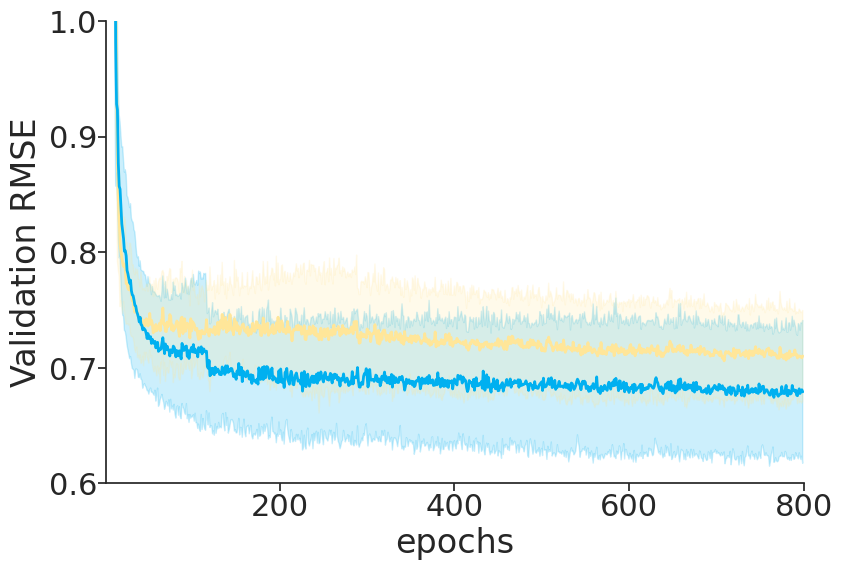

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1, legend=False)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

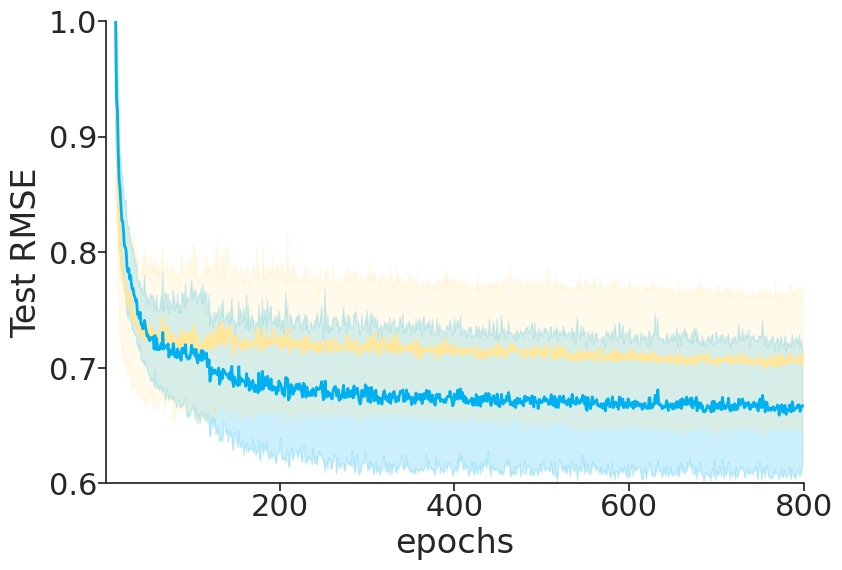

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1, legend=False)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

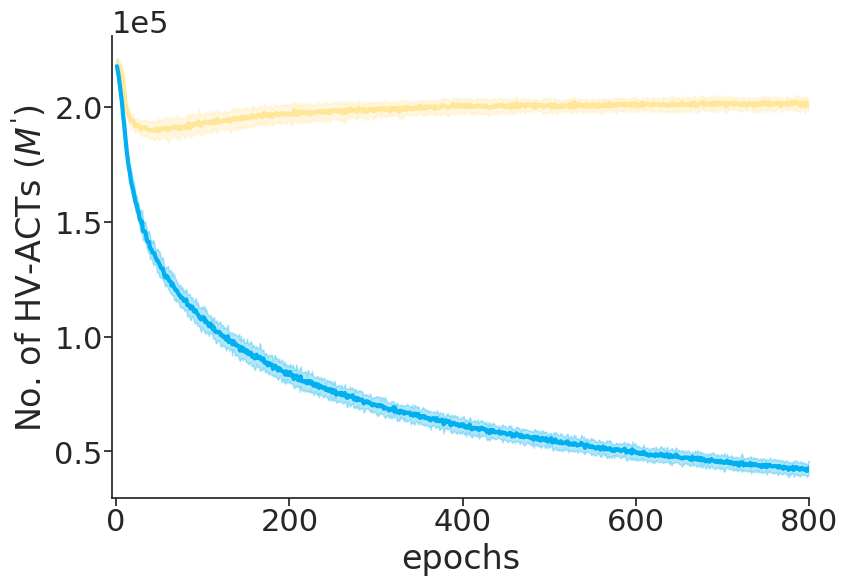

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1, legend=False)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

#ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

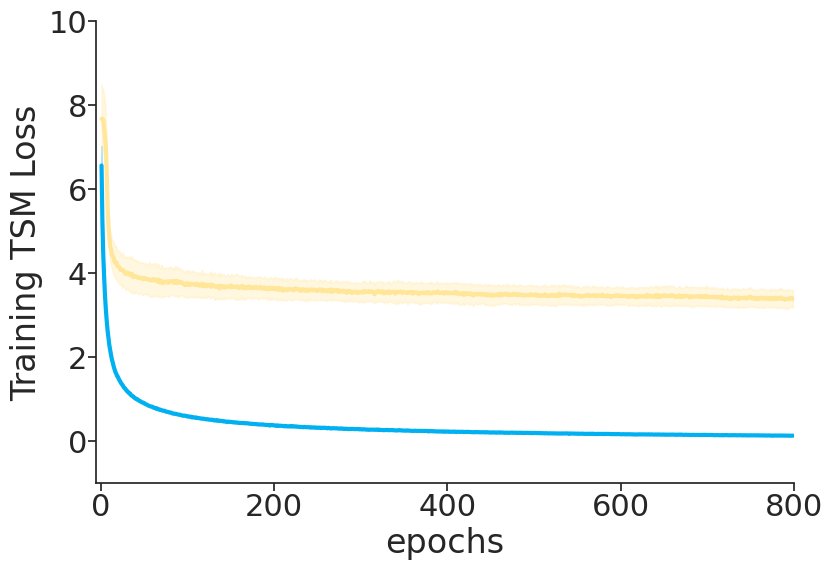

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1, legend=False)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

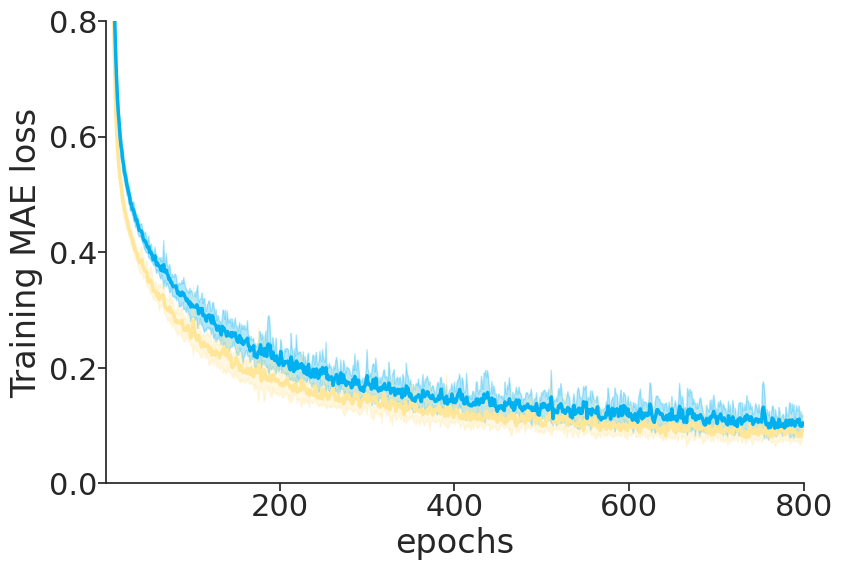

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1, legend=False)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)



ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
#ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 